## Importing important libraries & setting up foundation.

In [226]:
# Data wrangling
import calendar
import pandas as pd
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from math import radians, sin, cos, sqrt, atan2
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, cross_val_score

# Visualisation
import seaborn as sns
from IPython.display import Image
from matplotlib import pyplot as plt

# Model Training
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

# Model Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Reading in required libraries.
funnel_data = pd.read_csv("datasets/funnel_data.csv")
installer_locations = pd.read_csv("datasets/installer_locations.csv")
property_estimates = pd.read_csv("datasets/property_estimates.csv")

# Handling Warnings
import warnings
warnings.filterwarnings("ignore")

# Useful function for later.
def min_dist_calc(lat_1:float, lon_1:float, lat_2:list, lon_2:list) -> float:
    """
    Input:
        lat_1 (float): Latitude of first location
        lon_1 (float): Longitude of first location
        lat_2 (list): List of latitude to compare against for minimum
        lon_2 (list): List of Longitudes to compare against for minimum
        

    Output:
        min_distance_km (float): Minimum distance between locations in Kilometers.
    """
    try:
        lat_1 = radians(lat_1)
        lon_1 = radians(lon_1)
        
        R = 6371.0 # Radius of Earth.
        distances = [] # List of distances between all locations.

        for lat, lon in zip(lat_2, lon_2):
            lat = radians(lat)
            lon = radians(lon)
            
            dist_lon = lon - lon_1
            dist_lat = lat - lat_1
            
            a = sin(dist_lat / 2) **2 + cos(lat_1) * cos(lat) * sin(dist_lon / 2) **2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))
            distance_km = R * c
            
            distances.append(distance_km)
        min_distance_km = min(distances)
        
    except Exception:
        min_distance_km = None

    return min_distance_km

## Challenges:

- How does traffic to the website vary across the time period? Are there any notable
patterns in visits?
- How long from the first visit do people normally pay forthe design consultation?
- What percentage of people visiting the website went on to book a design
consultation?
- How does conversion of Design consultation payments vary based on eligibility to
theBoiler Upgrade Scheme grant?

### ***Addressing***: How does traffic to the website vary across the time period? Are there any notable patterns in visits?

In [227]:
# Understanding the data
print(funnel_data.info(),'\n')
print(funnel_data.isna().sum())
funnel_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5891 entries, 0 to 5890
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   home_id               5891 non-null   object 
 1   latest_state          5891 non-null   object 
 2   uprn                  5891 non-null   int64  
 3   post_code             5891 non-null   object 
 4   longitude             5891 non-null   float64
 5   latitude              5891 non-null   float64
 6   first_search          5891 non-null   object 
 7   views_before_dc_paid  3942 non-null   float64
 8   registered_user       452 non-null    object 
 9   dc_paid               58 non-null     object 
 10  dc_complete           37 non-null     object 
 11  proposal_inReview     30 non-null     object 
 12  deposit_paid          10 non-null     object 
 13  commission_complete   4 non-null      object 
 14  final_paid            3 non-null      object 
dtypes: float64(3), int64(

,home_id,latest_state,uprn,post_code,longitude,latitude,first_search,views_before_dc_paid,registered_user,dc_paid,dc_complete,proposal_inReview,deposit_paid,commission_complete,final_paid
0,zwdd8a,survey_assigned,10023385251,CV37 9DG,-1.724661,52.194523,2023-12-12,15.0,2023-12-12,2024-04-26,NaN,NaN,NaN,NaN,NaN
1,zarj5q,survey_assigned,100050897563,S26 6RB,-1.276795,53.340810,2023-12-03,1.0,2023-12-03,2024-03-25,NaN,NaN,NaN,NaN,NaN
2,zk895a,proposal_inReview,10009739974,IP32 6TE,0.693088,52.261592,2023-12-23,NaN,2023-12-23,2024-03-23,2024-04-26,2024-04-30,NaN,NaN,NaN
3,q5ovwa,survey_booked,100120394343,GL53 9EH,-2.068570,51.878346,2023-12-08,2.0,2023-12-08,2024-03-10,NaN,NaN,NaN,NaN,NaN
4,z7od2d,proposal_inProgress,100071212868,WV5 7DR,-2.304035,52.535440,2023-12-13,0.0,2023-12-13,2024-03-04,2024-04-06,NaN,NaN,NaN,NaN


In [228]:
# Correcting date columns type.
date_columns = ["first_search", "registered_user", "dc_paid", "dc_complete", "proposal_inReview", "deposit_paid", "commission_complete", "final_paid"]
funnel_data[date_columns] = funnel_data[date_columns].apply(pd.to_datetime)
funnel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5891 entries, 0 to 5890
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   home_id               5891 non-null   object        
 1   latest_state          5891 non-null   object        
 2   uprn                  5891 non-null   int64         
 3   post_code             5891 non-null   object        
 4   longitude             5891 non-null   float64       
 5   latitude              5891 non-null   float64       
 6   first_search          5891 non-null   datetime64[ns]
 7   views_before_dc_paid  3942 non-null   float64       
 8   registered_user       452 non-null    datetime64[ns]
 9   dc_paid               58 non-null     datetime64[ns]
 10  dc_complete           37 non-null     datetime64[ns]
 11  proposal_inReview     30 non-null     datetime64[ns]
 12  deposit_paid          10 non-null     datetime64[ns]
 13  commission_complet

In [229]:
# Time deltas for all dates

for col in date_columns:
    print(f"{col} time deltas: '{max(funnel_data[col]) - min(funnel_data[col])}'")

first_search time deltas: '29 days 00:00:00'
registered_user time deltas: '344 days 00:00:00'
dc_paid time deltas: '146 days 00:00:00'
dc_complete time deltas: 'NaT'
proposal_inReview time deltas: 'NaT'
deposit_paid time deltas: 'NaT'
commission_complete time deltas: 'NaT'
final_paid time deltas: 'NaT'


### ***Challenge***: How does traffic to the website vary across the time period? Are there any notable patterns in visits?

**Assumptions**:
- New User registration is done `strictly` online.
- Payments are made `strictly` online through Heat Geeks provided payment platform.
- Dc payments are paid in full and at once therefore no multiple visits for that.
- It is impossible to book dc without a first search.
- The term `visit` covers anything done online such as ***first search , user registration, dc payments, deposit payments, final payments, proposal review***. everything else is regarded as done ofline therefore doesn't require website access.
- Unprovided times `(NaT)` means no activity has been recorded on that activity yet. i.e Due to the approximately 3 months period it takes after design consultation before installation. `Most recorded dc_complete fall in January so installations are expected to be happenig now.`

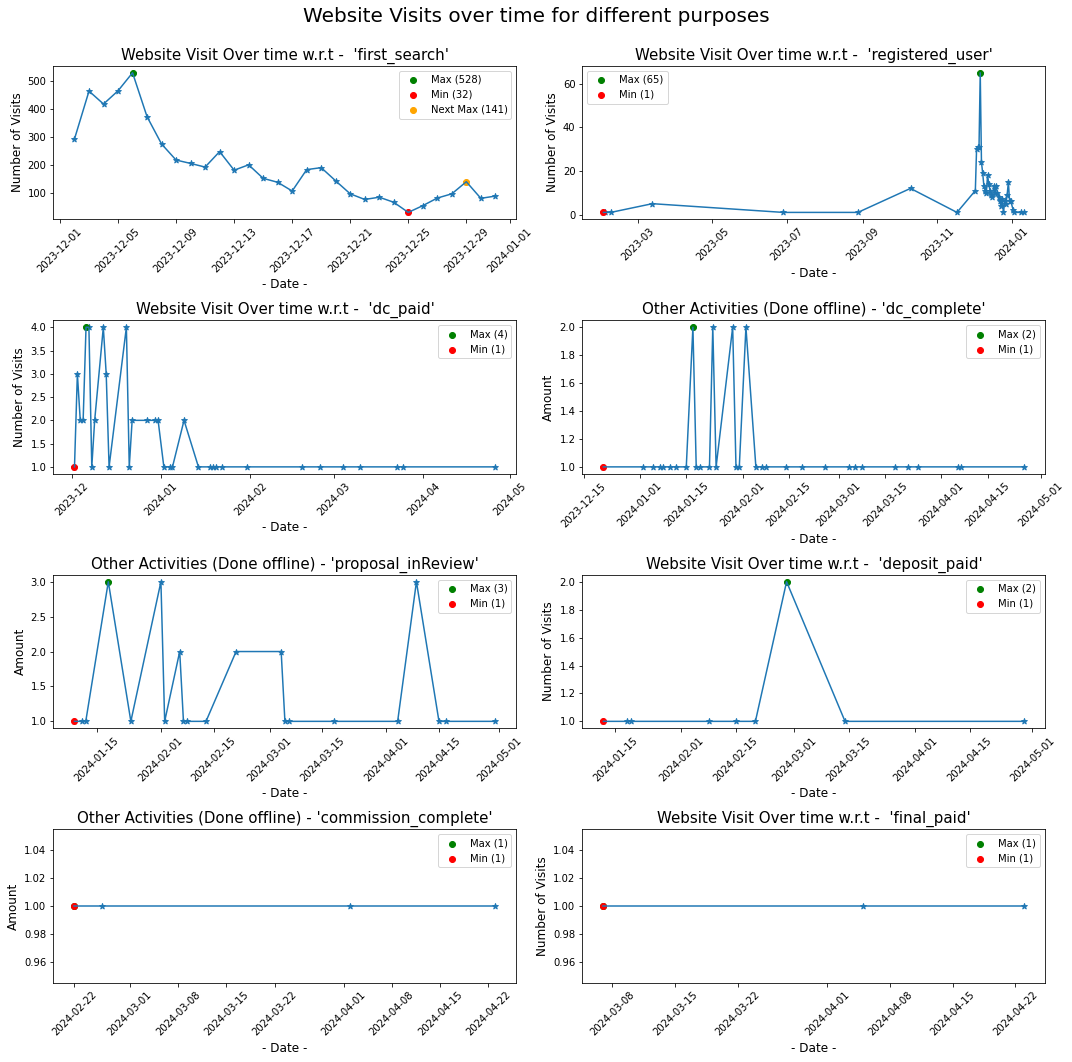

In [230]:
plt.figure(figsize = (15, 15))
plt.suptitle("Website Visits over time for different purposes", fontsize = 20)

for i, date_column in enumerate(date_columns, start = 1):
    visit = funnel_data.groupby(date_column).size() # Creating groups based on the dates and counting how many elements (data points) are in each group.
    
    plt.subplot(4, 2, i)
    plt.plot(visit.index, visit.values)
    plt.scatter(visit.index, visit.values, marker = '*')
    plt.xticks(rotation = 45)

    # Find maximum and minimum points
    max_index = visit.idxmax() # Maximum point index.
    min_index = visit.idxmin()
    max_value = visit[max_index] # Extracting value with index.
    min_value = visit[min_index]
    
    # Plot maximum and minimum points with green and red markers.
    plt.scatter(max_index, max_value, color="green", label = f'Max ({max_value})')
    plt.scatter(min_index, min_value, color="red", label = f'Min ({min_value})')

    # Plot the next maximum only for the first subplot.
    if i == 1: # Making sure it's the first plot only. Reason? All other first maximums appear after first minimums instead of reverse.
        next_max_index = visit.loc[visit.index > min_index].idxmax() # Extracting the index of max immediately after the minimum point.
        next_max_value = visit[next_max_index] # Extracting the value itself now.
        
        # Plot the next maximum point.
        if next_max_index is not pd.NaT:  # making sure there is an actual next max (not NaT)
            plt.scatter(next_max_index, next_max_value, color="orange", label = f'Next Max ({next_max_value})')

    if i in [4, 5, 7]:
        plt.title(f"Other Activities (Done offline) - '{date_column}'", fontsize = 15)
        plt.xlabel("- Date -", fontsize = 12)
        plt.ylabel("Amount", fontsize = 12)
        plt.legend()
    else:
        plt.title(f"Website Visit Over time w.r.t -  '{date_column}'", fontsize = 15)
        plt.xlabel("- Date -", fontsize = 12)
        plt.ylabel("Number of Visits", fontsize = 12)
        plt.legend()


plt.tight_layout(rect = [0, 0, 1, 0.98])
plt.savefig("stuff.pdf")
plt.show()

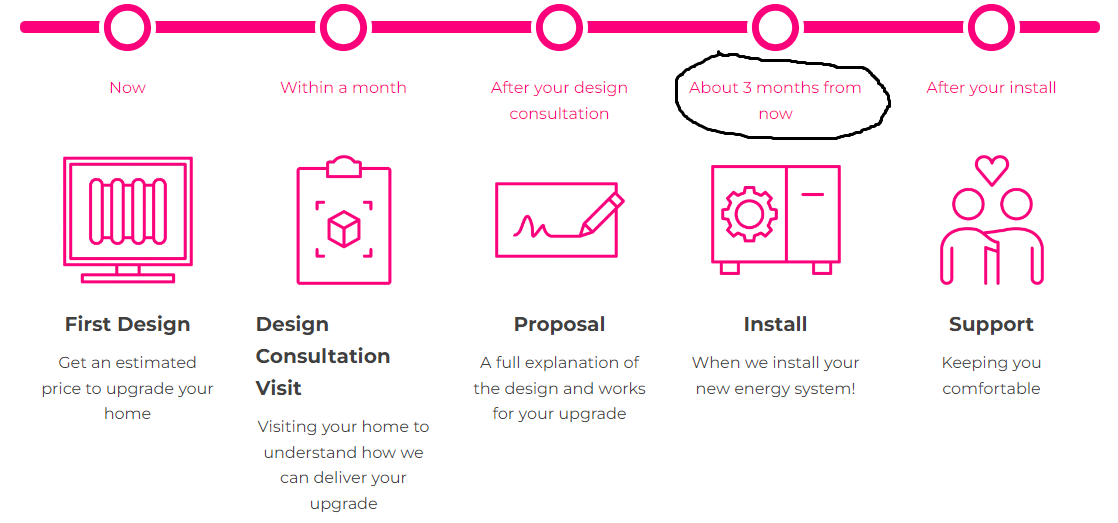

In [231]:
Image(filename = "geekprocess.png")

**Findings (w.r.t website visit)**:
- Peak first visit beginning of December 2023, visits progressively decreased thereafter.
    - Could the reason for peak visits be due to popular youtube video `Mixergy? THIS ALTERNATIVE CYLINDER IS 400% BETTER? - Nov 16, 2023`
    - Could the reson simply be because it is a festive season?
    - Could the reason for progressive decrease in visits be due to the holiday peaking? (`Minimum visits recorded on Christmas day`). Starts to climb back up thereafter.
- Due to peak visit in December 2023, Heat Geaks was also able to secure lots of new users in that same period.
- After many new users, several people also made payments for their design consultation during the December period followed by declines.
    - The number of visits fluctuated but remained at lower levels after the initial drop (after max) `suggesting an issue in converting leads into clients, NEEDS FURTHER INVESTIGATON`

**Extras**
- Completion of design consultation is showing similar behaviors to design consultation payments which should be so as with payment comes service.
- Over a period of 5 months, several clients received proposals however, a lot less have made their deposit payments.
    - Could this be because the homes are not eligible for the `Boiler Upgrade Scheme grant?` Further analysis will reveal that.   

**Reccomendations**
- Keep track of how many website visits they completed before they made an installation deposit (`Alternatively`: how many times they visited the website to review the proposal before warming up to it).
- The above may not necessarily capture if clients are re-reviewing proposals if downloading proposals was an option therefore tracking `proposal downloads` would be necessary as well if such option is provided.   

**Questions for business specialist**
- Can the same house (`Home_id` or `UPRN`) have multiple First_search?
    - In a case where a non-registered user searches for a house (their new/potential new home). How can we tell apart this un-registered users first search from another first search?.... ***Question useful for answering "What percentage of people visiting the website went on to book a design consultation"***

### ***Addressing***: How long from the first visit do people normally pay for the design consultation?

In [232]:
funnel_data["first_visit_dc_paid_time_delta"] = funnel_data["dc_paid"] - funnel_data["first_search"]
funnel_data['first_visit_dc_paid_time_delta_days'] = funnel_data['first_visit_dc_paid_time_delta'].dt.days
funnel_data.head()

,home_id,latest_state,uprn,post_code,longitude,latitude,first_search,views_before_dc_paid,registered_user,dc_paid,dc_complete,proposal_inReview,deposit_paid,commission_complete,final_paid,first_visit_dc_paid_time_delta,first_visit_dc_paid_time_delta_days
0,zwdd8a,survey_assigned,10023385251,CV37 9DG,-1.724661,52.194523,2023-12-12,15.0,2023-12-12,2024-04-26,NaT,NaT,NaT,NaT,NaT,136 days,136.0
1,zarj5q,survey_assigned,100050897563,S26 6RB,-1.276795,53.340810,2023-12-03,1.0,2023-12-03,2024-03-25,NaT,NaT,NaT,NaT,NaT,113 days,113.0
2,zk895a,proposal_inReview,10009739974,IP32 6TE,0.693088,52.261592,2023-12-23,NaN,2023-12-23,2024-03-23,2024-04-26,2024-04-30,NaT,NaT,NaT,91 days,91.0
3,q5ovwa,survey_booked,100120394343,GL53 9EH,-2.068570,51.878346,2023-12-08,2.0,2023-12-08,2024-03-10,NaT,NaT,NaT,NaT,NaT,93 days,93.0
4,z7od2d,proposal_inProgress,100071212868,WV5 7DR,-2.304035,52.535440,2023-12-13,0.0,2023-12-13,2024-03-04,2024-04-06,NaT,NaT,NaT,NaT,82 days,82.0


The minimum number of days is 0.00
The maximum time is 136.00 days or 4.0 months
The average is 17.71


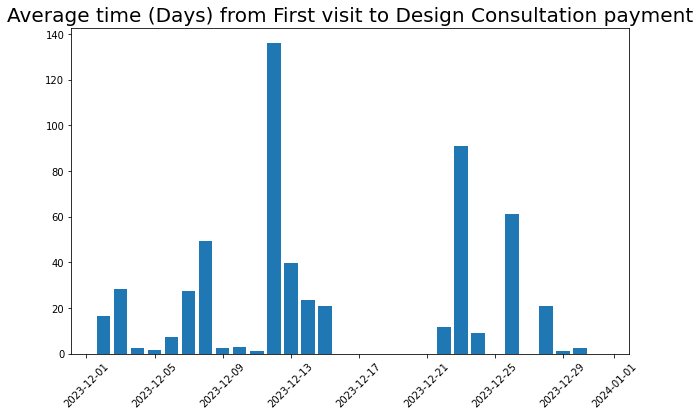

In [233]:
### ** Contains Important Info ** ###

average_values = funnel_data.groupby('first_search')['first_visit_dc_paid_time_delta_days'].mean()
average_values = average_values.dropna()

plt.figure(figsize=(10, 6))
plt.bar(average_values.keys(), average_values.values)
plt.title("Average time (Days) from First visit to Design Consultation payment", fontsize = 20)
plt.xticks(rotation = 45);

minimum_time_days = funnel_data["first_visit_dc_paid_time_delta_days"].dropna().min()
average_time_days = funnel_data["first_visit_dc_paid_time_delta_days"].dropna().mean()
maximum_time_days = funnel_data["first_visit_dc_paid_time_delta_days"].dropna().max()

print(f"The minimum number of days is {minimum_time_days:.2f}")
print(f"The maximum time is {maximum_time_days:.2f} days or {maximum_time_days // 30} months")
print(f"The average is {average_time_days:.2f}")
print(average_values.values.median())

In [239]:
import numpy as np
np.median(np.array(average_values.values))

9.0

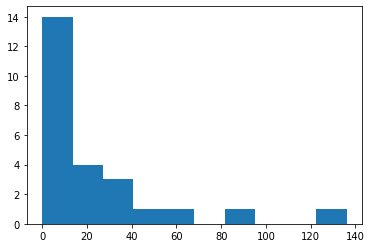

In [236]:
# When performing analysis next time and min, max and mean seem suspecious, LOOK AT MEDIAN AS WELL! 
plt.hist(average_values.values);

### ***Addressing***: What percentage of people visiting the website went on to book a design consultation?

In [190]:
print(len(funnel_data.home_id.unique()))

5891


*** Overall ***
Number of people visiting: 5891
Number of people who booked consulting: 58
0.98% of people visiting the website went on to book a design consultation.... Stragne? NO

***********************************************************************************
Please NOTE that each month below is in 2024 EXCEPT December which is from 2023.
***********************************************************************************

Bookings by month	First visits by month	Percentage booked	Percentage of December visits who later booked in other months
January - 11        		0			0.00%				0.19%
February - 2         		0			0.00%				0.03%
March - 4         		0			0.00%				0.07%
April - 1         		0			0.00%				0.02%
May - 0         		0			0.00%				0.00%
June - 0         		0			0.00%				0.00%
July - 0         		0			0.00%				0.00%
August - 0         		0			0.00%				0.00%
September - 0         		0			0.00%				0.00%
October - 0         		0			0.00%				0.00%
November - 0         		0			0.00%				0.00%
Decemb

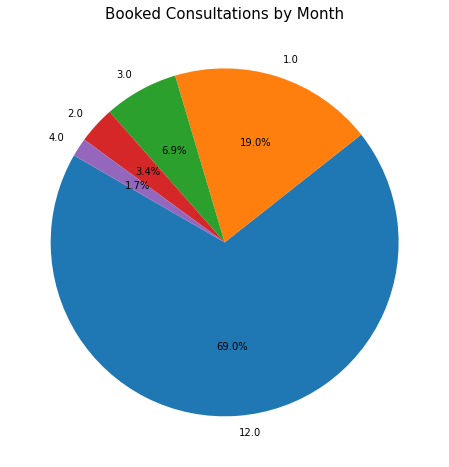

In [191]:
### ** Contains Important Info ** ###

# Assumptions:
# Design consultations bookings are confirmed with dc payments in full. 

months_lab = ["January 2024", "Februray 2024", "March 2024", "April 2024", "December 2023"]

funnel_data["booked_consultation"] = funnel_data["dc_paid"].apply(lambda x: 1 if str(x) != str(pd.NaT) else 0)
funnel_data['dc_paid_month'] = funnel_data['dc_paid'].dt.month

# Since one books a consultation after first search which can be done before or after registration, considering first search
# is a safe way to understand people who "Visited the website before booking a design consultation"
funnel_data["visited_site_before_dc_paid"] = funnel_data.apply(lambda x: 1 if str(x["first_search"]) != str(pd.NaT) else 0, axis = 1)

percentage_of_visit_booked_before_dc = (sum(funnel_data["booked_consultation"]) / sum(funnel_data["visited_site_before_dc_paid"])) * 100

print("*** Overall ***")
print(f"Number of people visiting:", sum(funnel_data["visited_site_before_dc_paid"]))
print(f"Number of people who booked consulting:", sum(funnel_data["booked_consultation"]))
print(f"{percentage_of_visit_booked_before_dc:.2f}% of people visiting the website went on to book a design consultation.... Stragne? NO")


print("\n***********************************************************************************")
print("Please NOTE that each month below is in 2024 EXCEPT December which is from 2023.")
print("***********************************************************************************")


booked_consultations_by_month = funnel_data.dc_paid.dt.month.value_counts()
print("\nBookings by month\tFirst visits by month\tPercentage booked\tPercentage of December visits who later booked in other months")
december_first_visits = funnel_data[funnel_data.first_search.dt.month == 12].shape[0]


for month in range(1, 13):
    month_name = calendar.month_name[month]
    bookings = booked_consultations_by_month.get(month, 0)
    first_visits = funnel_data[funnel_data.first_search.dt.month == month].shape[0]
    percentage_booked = (bookings / first_visits) * 100 if first_visits != 0 else 0
    percentage_december_visits = (bookings / december_first_visits) * 100 if december_first_visits != 0 else 0
    print(f"{month_name} - {bookings:<10}\t\t{first_visits}\t\t\t{percentage_booked:.2f}%\t\t\t\t{percentage_december_visits:.2f}%")

print("\nPercentage of people who booked Design Consultation in each month after visiting")
plt.figure(figsize = (8, 8), facecolor = "white")
plt.pie(booked_consultations_by_month, labels = booked_consultations_by_month.keys(), autopct = "%1.1f%%", startangle = 150)
plt.title("Booked Consultations by Month", fontsize = 15);

### ***Addressing***: How does conversion of Design consultation payments vary based on eligibility to the Boiler Upgrade Scheme grant?

In [192]:
### ** Contains Important Info ** ###

funnel_intelligence = pd.merge(funnel_data, property_estimates, on = "uprn", how = "inner")

eligible_homes = funnel_intelligence[funnel_intelligence["is_bus_eligible"] == True]
non_eligible_homes = funnel_intelligence[funnel_intelligence["is_bus_eligible"] == False]

overall_conversion_rate_eligible = (eligible_homes["booked_consultation"].mean()) * 100
overall_conversion_rate_non_eligible = (non_eligible_homes["booked_consultation"].mean()) * 100
monthly_conversion_rates = funnel_intelligence.groupby(["dc_paid_month", "is_bus_eligible"])["booked_consultation"].mean() * 100


print("*** Overall ***")
print(f"Conversion Rate for Eligible Homes: {overall_conversion_rate_eligible:.2f}%")
print(f"Conversion Rate for Non-Eligible Homes: {overall_conversion_rate_non_eligible:.2f}% \n\n")

print("Conversion Rates for Each Month that there was a Conversion:\n")
monthly_conversion_rates = monthly_conversion_rates.unstack(fill_value = 0.0)
print(monthly_conversion_rates.T)
print("All months above are 2024 except December (12) of 2023.")

*** Overall ***
Conversion Rate for Eligible Homes: 1.63%
Conversion Rate for Non-Eligible Homes: 0.59% 


Conversion Rates for Each Month that there was a Conversion:

dc_paid_month     1.0    2.0    3.0    4.0    12.0
is_bus_eligible                                   
False            100.0    0.0  100.0    0.0  100.0
True             100.0  100.0  100.0  100.0  100.0
All months above are 2024 except December (12) of 2023.


### ***Addressing***: For any website visit, can you predictthe chance that they are going to convert to a DC booking?

In [193]:
funnel_intelligence_distance = funnel_intelligence.copy()

funnel_intelligence_distance["closest_installer_dist_km"] = funnel_intelligence_distance.apply(lambda x: min_dist_calc(x["latitude"], x["longitude"], installer_locations["latitude"], installer_locations["longitude"]), axis = 1)
funnel_intelligence_distance.head()

,home_id,latest_state,uprn,post_code,longitude,latitude,first_search,views_before_dc_paid,registered_user,dc_paid,...,first_visit_dc_paid_time_delta_days,booked_consultation,dc_paid_month,visited_site_before_dc_paid,property_type,floor_area,property_age,is_bus_eligible,heat_loss_kw,closest_installer_dist_km
0,zwdd8a,survey_assigned,10023385251,CV37 9DG,-1.724661,52.194523,2023-12-12,15.0,2023-12-12,2024-04-26,...,136.0,1,4.0,1,Detached house,135.0,Post-1996,True,4.41,31.661623
1,z2rrk9,survey_created,10023385251,CV37 9DG,-1.724661,52.194523,2023-12-11,0.0,NaT,NaT,...,NaN,0,NaN,1,Detached house,135.0,Post-1996,True,4.41,31.661623
2,zarj5q,survey_assigned,100050897563,S26 6RB,-1.276795,53.340810,2023-12-03,1.0,2023-12-03,2024-03-25,...,113.0,1,3.0,1,Semi-detached house,84.0,1930-1949,True,4.39,4.194532
3,zk895a,proposal_inReview,10009739974,IP32 6TE,0.693088,52.261592,2023-12-23,NaN,2023-12-23,2024-03-23,...,91.0,1,3.0,1,Detached house,84.0,Post-1996,True,2.87,42.029424
4,3n5dpa,survey_created,10009739974,IP32 6TE,0.693088,52.261592,2023-12-21,NaN,NaT,NaT,...,NaN,0,NaN,1,Detached house,84.0,Post-1996,True,2.87,42.029424


In [194]:
funnel_intelligence_distance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6263 entries, 0 to 6262
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype          
---  ------                               --------------  -----          
 0   home_id                              6263 non-null   object         
 1   latest_state                         6263 non-null   object         
 2   uprn                                 6263 non-null   int64          
 3   post_code                            6263 non-null   object         
 4   longitude                            6263 non-null   float64        
 5   latitude                             6263 non-null   float64        
 6   first_search                         6263 non-null   datetime64[ns] 
 7   views_before_dc_paid                 4208 non-null   float64        
 8   registered_user                      496 non-null    datetime64[ns] 
 9   dc_paid                              67 non-null     datetime64[ns] 
 10  

In [195]:
funnel_intelligence_distance.head()

,home_id,latest_state,uprn,post_code,longitude,latitude,first_search,views_before_dc_paid,registered_user,dc_paid,...,first_visit_dc_paid_time_delta_days,booked_consultation,dc_paid_month,visited_site_before_dc_paid,property_type,floor_area,property_age,is_bus_eligible,heat_loss_kw,closest_installer_dist_km
0,zwdd8a,survey_assigned,10023385251,CV37 9DG,-1.724661,52.194523,2023-12-12,15.0,2023-12-12,2024-04-26,...,136.0,1,4.0,1,Detached house,135.0,Post-1996,True,4.41,31.661623
1,z2rrk9,survey_created,10023385251,CV37 9DG,-1.724661,52.194523,2023-12-11,0.0,NaT,NaT,...,NaN,0,NaN,1,Detached house,135.0,Post-1996,True,4.41,31.661623
2,zarj5q,survey_assigned,100050897563,S26 6RB,-1.276795,53.340810,2023-12-03,1.0,2023-12-03,2024-03-25,...,113.0,1,3.0,1,Semi-detached house,84.0,1930-1949,True,4.39,4.194532
3,zk895a,proposal_inReview,10009739974,IP32 6TE,0.693088,52.261592,2023-12-23,NaN,2023-12-23,2024-03-23,...,91.0,1,3.0,1,Detached house,84.0,Post-1996,True,2.87,42.029424
4,3n5dpa,survey_created,10009739974,IP32 6TE,0.693088,52.261592,2023-12-21,NaN,NaT,NaT,...,NaN,0,NaN,1,Detached house,84.0,Post-1996,True,2.87,42.029424


In [196]:
funnel_intelligence_distance.property_type.value_counts()

Detached house                                         3164
Semi-detached house                                    1939
Mid-terraced house                                      649
End-terraced house                                      484
Small block of flats/dwelling converted in to flats      16
Flat in mixed use building                                5
Block of flats                                            3
Large block of flats                                      3
Name: property_type, dtype: int64

In [197]:
# Handling all categorical, date, and unnecessary columns.

dates = ["first_search", "registered_user"]
categorical = ["latest_state", "property_type", "property_age", "is_bus_eligible"]
unnecessary = ["home_id", "uprn", "dc_paid", "first_visit_dc_paid_time_delta", "first_visit_dc_paid_time_delta_days", "dc_paid_month", "visited_site_before_dc_paid", "post_code", "latitude", "longitude", "dc_complete", "proposal_inReview", "deposit_paid", "commission_complete", "final_paid", "first_search", "registered_user"]


# Handling date columns
for col in dates:
    funnel_intelligence_distance[f"{col}_month"] = funnel_intelligence_distance[col].apply(lambda x: (x.month))
    funnel_intelligence_distance[f"{col}_month"] = funnel_intelligence_distance[f"{col}_month"].fillna(0) # Using 0 to fill in unspecified date.

# Dropping all unnecessary columns (I deamed them unnecessary because they're either identifiers or things that occur after dc booking or
# I have engineered the original feature.)
funnel_intelligence_distance.drop(unnecessary, inplace = True, axis = 1)

# Encoding categorical data columns.
latent_state_encoder = LabelEncoder()
property_type_encoder = LabelEncoder()
property_age_encoder = LabelEncoder()
is_bus_eligible_encoder = LabelEncoder()

funnel_intelligence_distance["latest_state"] = latent_state_encoder.fit_transform(funnel_intelligence_distance["latest_state"])
funnel_intelligence_distance["property_type"] = property_type_encoder.fit_transform(funnel_intelligence_distance["property_type"])
funnel_intelligence_distance["property_age"] = property_age_encoder.fit_transform(funnel_intelligence_distance["property_age"])
funnel_intelligence_distance["is_bus_eligible"] = is_bus_eligible_encoder.fit_transform(funnel_intelligence_distance["is_bus_eligible"])

funnel_intelligence_distance.head()

,latest_state,views_before_dc_paid,booked_consultation,property_type,floor_area,property_age,is_bus_eligible,heat_loss_kw,closest_installer_dist_km,first_search_month,registered_user_month
0,6,15.0,1,1,135.0,5,1,4.41,31.661623,12,12.0
1,8,0.0,0,1,135.0,5,1,4.41,31.661623,12,0.0
2,6,1.0,1,6,84.0,1,1,4.39,4.194532,12,12.0
3,5,NaN,1,1,84.0,5,1,2.87,42.029424,12,12.0
4,8,NaN,0,1,84.0,5,1,2.87,42.029424,12,0.0


In [198]:
funnel_intelligence_distance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6263 entries, 0 to 6262
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   latest_state               6263 non-null   int32  
 1   views_before_dc_paid       4208 non-null   float64
 2   booked_consultation        6263 non-null   int64  
 3   property_type              6263 non-null   int32  
 4   floor_area                 6263 non-null   float64
 5   property_age               6263 non-null   int32  
 6   is_bus_eligible            6263 non-null   int64  
 7   heat_loss_kw               6263 non-null   float64
 8   closest_installer_dist_km  6263 non-null   float64
 9   first_search_month         6263 non-null   int64  
 10  registered_user_month      6263 non-null   float64
dtypes: float64(5), int32(3), int64(3)
memory usage: 513.8 KB


In [199]:
funnel_intelligence_distance.describe()

,latest_state,views_before_dc_paid,booked_consultation,property_type,floor_area,property_age,is_bus_eligible,heat_loss_kw,closest_installer_dist_km,first_search_month,registered_user_month
count,6263.000000,4208.000000,6263.000000,6263.000000,6263.000000,6263.000000,6263.000000,6263.000000,6263.000000,6263.0,6263.000000
mean,7.969663,0.057272,0.010698,3.057640,119.224634,2.760179,0.459524,5.602262,23.603431,12.0,0.922721
std,0.379580,0.798620,0.102883,2.311297,45.651281,1.781133,0.498399,2.299876,18.951723,0.0,3.181274
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006315,12.0,0.000000
25%,8.000000,0.000000,0.000000,1.000000,85.600000,1.000000,0.000000,3.930000,10.355516,12.0,0.000000
50%,8.000000,0.000000,0.000000,1.000000,112.000000,3.000000,0.000000,5.100000,19.148850,12.0,0.000000
75%,8.000000,0.000000,0.000000,6.000000,144.000000,4.000000,1.000000,6.875000,32.667587,12.0,0.000000
max,10.000000,29.000000,1.000000,7.000000,385.000000,6.000000,1.000000,19.540000,163.319372,12.0,12.000000


In [200]:
funnel_intelligence_distance.views_before_dc_paid.value_counts()

0.0     4159
2.0       13
1.0       10
3.0        6
8.0        5
5.0        4
4.0        3
20.0       2
9.0        2
15.0       1
29.0       1
7.0        1
6.0        1
Name: views_before_dc_paid, dtype: int64

### Missing Data Handling Strategy: `views_before_dc_paid`

Since the proportion of non-null count outweighs that of null count, and the amount of 0's counts for more than 80% of the known values, filling na with 0 or the mean is a viable option. However, I'll be filling with the median as a strategy to combat outliers.

In [201]:
median = funnel_intelligence_distance["views_before_dc_paid"].median()
funnel_intelligence_distance["views_before_dc_paid"] = funnel_intelligence_distance["views_before_dc_paid"].fillna(median)


### Identifying and Handling Outliers

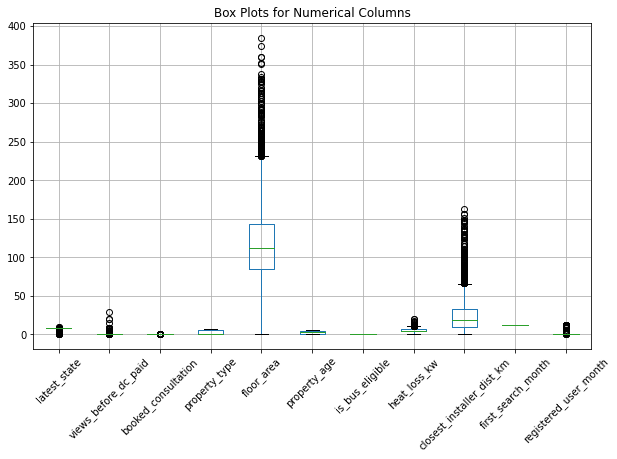

In [202]:
funnel_intelligence_distance.boxplot(figsize=(10, 6))
plt.title('Box Plots for Numerical Columns')
plt.xticks(rotation = 45) 
plt.show()

In [203]:
print("Data Inbalance before oytlier removal")
funnel_intelligence_distance.booked_consultation.value_counts()

Data Inbalance before oytlier removal


0    6196
1      67
Name: booked_consultation, dtype: int64

In [204]:
outlier_prones = ["floor_area", "heat_loss_kw"]

for outlier_prone in outlier_prones:
    min_value = funnel_intelligence_distance[outlier_prone].quantile(0.05)
    max_value = funnel_intelligence_distance[outlier_prone].quantile(0.9)
    
    funnel_intelligence_distance = funnel_intelligence_distance[(funnel_intelligence_distance[outlier_prone] > min_value) & (funnel_intelligence_distance[outlier_prone] <= max_value)]

# I had to allow some obvious outliers because I was loosing too much data hence the chosen qualtile amounts.

In [205]:
funnel_intelligence_distance.describe()

,latest_state,views_before_dc_paid,booked_consultation,property_type,floor_area,property_age,is_bus_eligible,heat_loss_kw,closest_installer_dist_km,first_search_month,registered_user_month
count,4532.000000,4532.000000,4532.000000,4532.000000,4532.000000,4532.000000,4532.000000,4532.000000,4532.000000,4532.0,4532.000000
mean,7.967785,0.042145,0.010150,3.158429,109.119320,2.614298,0.445499,5.036600,23.305623,12.0,0.948147
std,0.395097,0.734278,0.100246,2.326203,26.794202,1.638601,0.497076,1.237109,18.554938,0.0,3.219026
min,0.000000,0.000000,0.000000,1.000000,64.040000,0.000000,0.000000,3.030000,0.006315,12.0,0.000000
25%,8.000000,0.000000,0.000000,1.000000,86.585000,1.000000,0.000000,4.050000,10.110399,12.0,0.000000
50%,8.000000,0.000000,0.000000,2.000000,106.230000,3.000000,0.000000,4.870000,19.234183,12.0,0.000000
75%,8.000000,0.000000,0.000000,6.000000,128.000000,4.000000,1.000000,5.890000,32.349132,12.0,0.000000
max,10.000000,29.000000,1.000000,7.000000,176.000000,6.000000,1.000000,7.900000,163.319372,12.0,12.000000


In [206]:
print("Data Inbalance after oytlier removal")
funnel_intelligence_distance.booked_consultation.value_counts()

Data Inbalance after oytlier removal


0    4486
1      46
Name: booked_consultation, dtype: int64

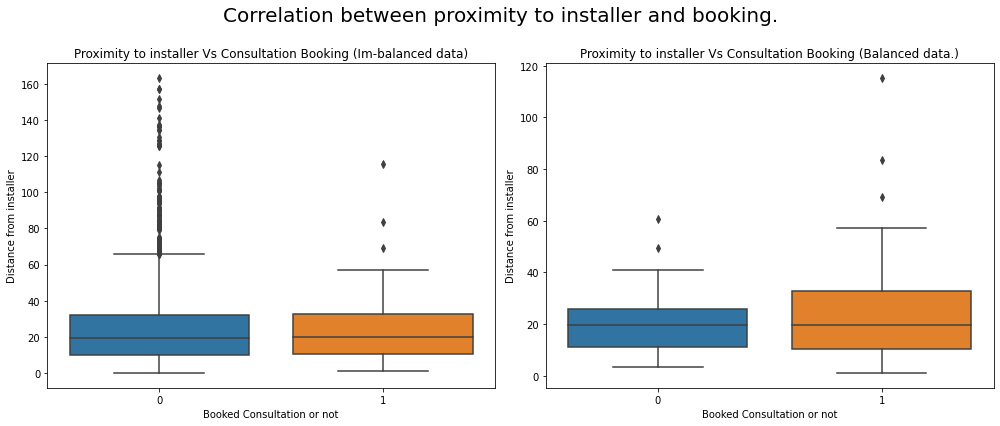

In [225]:
# ****Quick glance.****


booked = funnel_intelligence_distance[funnel_intelligence_distance["booked_consultation"] == 1]
num_booked = len(funnel_intelligence_distance[funnel_intelligence_distance["booked_consultation"] == 1])

didnt_book_index = funnel_intelligence_distance[funnel_intelligence_distance["booked_consultation"] == 0].sample(num_booked, random_state = 36).index
didnt_book = funnel_intelligence_distance.loc[didnt_book_index] # Collecting sample of those who didn't book.
combined = pd.concat([booked, didnt_book], ignore_index = True)


# Original boxplot (The one with inbalanced data)
plt.figure(figsize = (14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x = "booked_consultation", y = "closest_installer_dist_km", data = funnel_intelligence_distance)
plt.xlabel("Booked Consultation or not")
plt.ylabel("Distance from installer")
plt.title("Proximity to installer Vs Consultation Booking (Im-balanced data)")

# Balanced data.
plt.subplot(1, 2, 2)
sns.boxplot(x = "booked_consultation", y = "closest_installer_dist_km", data = combined)
plt.xlabel("Booked Consultation or not")
plt.ylabel("Distance from installer")
plt.title("Proximity to installer Vs Consultation Booking (Balanced data.)")

plt.suptitle("Correlation between proximity to installer and booking.", fontsize = 20)
plt.tight_layout(rect = [0, 0, 1, 0.98])
plt.show()

In [176]:
# REMEMBER PyCaret next time (makes life easier, speeds up feature selection, and more.)
# https://github.com/pycaret/pycaret/blob/master/tutorials/Tutorial%20-%20Binary%20Classification.ipynb

shuffled_data = funnel_intelligence_distance.sample(frac = 1, random_state = 36)

X = shuffled_data.drop(columns = ["booked_consultation"])
y = shuffled_data["booked_consultation"]

classifiers = {
    'XGBoost': XGBClassifier(eval_metric = "logloss"),
    'SVM': SVC(probability = True),
    'Decision Tree': DecisionTreeClassifier()
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 36)

#  Train and evaluate each classifier
for clf_name, clf in classifiers.items():
    print(f"\n\n\t\t****Training {clf_name}****")

    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = "accuracy")
    print(f"Cross-validation accuracy scores for {clf_name}: {scores}")
    print(f"Mean CV accuracy for {clf_name}: {scores.mean()}")

    clf.fit(X_train, y_train)

    # Predict probabilities for 5 samples from the test set
    sample_indices = X_test.sample(5, random_state = 36).index
    sample_X = X_test.loc[sample_indices]
    sample_y_true = y_test.loc[sample_indices]
    sample_y_pred_proba = clf.predict_proba(sample_X)  # Predict probabilities
    sample_y_pred = clf.predict(sample_X)  # Predict labels

    # Display predicted probabilities alongside true target values.
    print(f"Predicted Probabilities for 5 Sample Instances (Classifier: {clf_name}):")
    for i, (true, pred_proba, pred) in enumerate(zip(sample_y_true, sample_y_pred_proba, sample_y_pred), start = 1):
        print(f"\nSample {i} - True Target: {true}")
        print(f"Predicted Probability for Class 0: {pred_proba[0]:.4f}")
        print(f"Predicted Probability for Class 1: {pred_proba[1]:.4f}")
        print(f"Predicted Label: {pred}")

    print(f"\nConfusion Matrix for {clf_name}:")
    cm = confusion_matrix(y_test, clf.predict(X_test))
    print(cm)

    print(f"\nClassification Report for {clf_name}:")
    print(classification_report(y_test, clf.predict(X_test)))



		****Training XGBoost****
Cross-validation accuracy scores for XGBoost: [1.         1.         0.99862069 0.99724138 0.99862069]
Mean CV accuracy for XGBoost: 0.9988965517241379
Predicted Probabilities for 5 Sample Instances (Classifier: XGBoost):

Sample 1 - True Target: 0
Predicted Probability for Class 0: 0.9999
Predicted Probability for Class 1: 0.0001
Predicted Label: 0

Sample 2 - True Target: 0
Predicted Probability for Class 0: 0.9999
Predicted Probability for Class 1: 0.0001
Predicted Label: 0

Sample 3 - True Target: 0
Predicted Probability for Class 0: 0.9999
Predicted Probability for Class 1: 0.0001
Predicted Label: 0

Sample 4 - True Target: 0
Predicted Probability for Class 0: 0.9999
Predicted Probability for Class 1: 0.0001
Predicted Label: 0

Sample 5 - True Target: 0
Predicted Probability for Class 0: 0.9998
Predicted Probability for Class 1: 0.0002
Predicted Label: 0

Confusion Matrix for XGBoost:
[[894   0]
 [  0  13]]

Classification Report for XGBoost:
         

In [177]:
sampling_pipeline = Pipeline([
    ('over', SMOTE(sampling_strategy = 0.5)),  # Increase the minority class to 50% of the majority class.
    ('under', RandomUnderSampler(sampling_strategy = 0.8))  # Decrease the majority class to 80% of the minority class.
])

# Applying SMOTE and RandomUnderSampler to the training data.
X_train_resampled, y_train_resampled = sampling_pipeline.fit_resample(X_train, y_train)

# Initialize classifiers
classifiers = {
    "XGBoost Classifier": XGBClassifier(eval_metric = "logloss"),
    "SVM Classifier": SVC(probability = True),
    "Decision Tree Classifier": DecisionTreeClassifier()
}

# Training and evaluate each classifier.
for clf_name, clf in classifiers.items():
    print(f"\n\n\t\t****Training {clf_name}****")

    # Cross-validation
    scores = cross_val_score(clf, X_train_resampled, y_train_resampled, cv = 5, scoring = "accuracy")
    print(f"Cross-validation accuracy scores for {clf_name}: {scores}")
    print(f"Mean CV accuracy for {clf_name}: {scores.mean()}")

    clf.fit(X_train_resampled, y_train_resampled)

    # Predict probabilities for 5 samples from the test set.
    sample_indices = X_test.sample(5, random_state = 36).index
    sample_X = X_test.loc[sample_indices]
    sample_y_true = y_test.loc[sample_indices]
    sample_y_pred_proba = clf.predict_proba(sample_X)  # Predict probabilities.
    sample_y_pred = clf.predict(sample_X)  # Predict labels.

    print(f"Predicted Probabilities for 5 Sample Instances (Classifier: {clf_name}):")
    for i, (true, pred_proba, pred) in enumerate(zip(sample_y_true, sample_y_pred_proba, sample_y_pred), start = 1):
        print(f"\nSample {i} - True Target: {true}")
        print(f"Predicted Probability for Class 0: {pred_proba[0]:.4f}")
        print(f"Predicted Probability for Class 1: {pred_proba[1]:.4f}")
        print(f"Predicted Label: {pred}")

    print(f"\nConfusion Matrix for {clf_name}:")
    cm = confusion_matrix(y_test, clf.predict(X_test))
    print(cm)

    print(f"\nClassification Report for {clf_name}:")
    print(classification_report(y_test, clf.predict(X_test)))




		****Training XGBoost Classifier****
Cross-validation accuracy scores for XGBoost Classifier: [1.         1.         1.         1.         0.99876238]
Mean CV accuracy for XGBoost Classifier: 0.9997524752475246
Predicted Probabilities for 5 Sample Instances (Classifier: XGBoost Classifier):

Sample 1 - True Target: 0
Predicted Probability for Class 0: 0.9999
Predicted Probability for Class 1: 0.0001
Predicted Label: 0

Sample 2 - True Target: 0
Predicted Probability for Class 0: 0.9995
Predicted Probability for Class 1: 0.0005
Predicted Label: 0

Sample 3 - True Target: 0
Predicted Probability for Class 0: 0.9998
Predicted Probability for Class 1: 0.0002
Predicted Label: 0

Sample 4 - True Target: 0
Predicted Probability for Class 0: 0.9998
Predicted Probability for Class 1: 0.0002
Predicted Label: 0

Sample 5 - True Target: 0
Predicted Probability for Class 0: 0.9999
Predicted Probability for Class 1: 0.0001
Predicted Label: 0

Confusion Matrix for XGBoost Classifier:
[[893   1]
 [

In [178]:
y_train_resampled.value_counts()

0    2245
1    1796
Name: booked_consultation, dtype: int64

## Conclusion:

- Worse performing classifier `SVM`. Moving forward, I'd work with XGB or Decision Trees for this data.
- The dataset is too small to achieve any sbstantially reliable performance in production, 

In [179]:
y_test.value_counts()

0    894
1     13
Name: booked_consultation, dtype: int64